<a href="https://colab.research.google.com/github/dominiksakic/generative_ai/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intuition
- a GAN functions, we train to make fake images.
- Send a batch of fakes and real images to assesment.
- use feedback to create better fakes. And the assesment becomes more cirtical too. Both increase over time.
- Endresult is that we have fake looking reals.

- part 1: Generator network; input vector from latent space.
- part 2: adversay; predicts whether the image came form the training set or was fake.

# Top down:
- generator that maps vecotrs of shape (latent_dim,) to images of shape (64,64,3)

- discriminator maps images of shape (64,64,3) to a binary score/estimation

- gan(x) = discriminator(generator(x))

- train on fakes and reals

- generators weights with regard to  the loss of  the gan model. Each step changes the weights in order to to get more real labels. In other words, we train the generator to fool the discriminator.

In [2]:
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=fd62e28b-b778-4e14-a86a-1f78e9131dbf
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:28<00:00, 49.8MB/s]


In [3]:
import tensorflow as tf
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,)

dataset = dataset.map(lambda x: tf.image.resize(x, (64, 64)))
dataset = dataset.map(lambda x: x / 255.)

Found 202599 files.


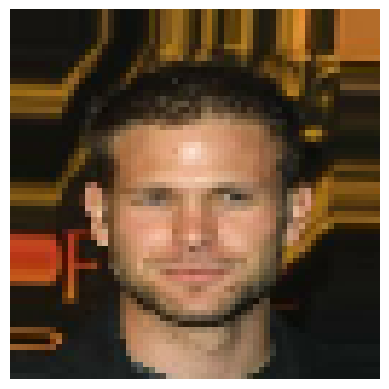

In [4]:
import matplotlib.pyplot as plt
for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype("int32")[0])
  break

In [5]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
    )

discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(
        shape=(batch_size, self.latent_dim))
    generated_images = self.generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
        axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)

    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
        )

    random_latent_vectors = tf.random.normal(
        shape=(batch_size, self.latent_dim))

    misleading_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as tape:
      predictions = self.discriminator(
          self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
      zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}

In [8]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(
        shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f"generated_img_{epoch:03d}_{i}.png")

In [9]:
epochs = 100

gan = GAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim)

gan.compile(
  d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
  g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
  loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
  dataset, epochs=epochs,
  callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 158s 23ms/step - d_loss: 0.5686 - g_loss: 1.2765
Epoch 2/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6500 - g_loss: 1.0947
Epoch 3/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6602 - g_loss: 0.9910
Epoch 4/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6430 - g_loss: 1.0741
Epoch 5/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.5955 - g_loss: 1.1859
Epoch 6/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6459 - g_loss: 1.0422
Epoch 7/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6589 - g_loss: 0.9971
Epoch 8/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - d_loss: 0.6626 - g_loss: 0.9229
Epoch 9/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6722 - g_loss: 0.9166
Epoch 10/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6834 - g_loss: 0.9070
Epoch 11/100
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - d_loss: 0.6692 - g

In [11]:
gan.save("gan_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


# Heuristics for GANs:
- use Strides not pooling, to not loose information
- sample points from the latent space using a normal distribution not a uniform distribution
- random noise is a good thing, so add randomness to the labels for the discriminator.
- sparse gradients can hinder GAN training -> use LeakyRelu and strided convolutions
- use a kernel size that sdivisible by the stride size to prevent chckerboard artifacts.